In [1]:
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import optax
from PIL import Image
import jax.numpy as jnp
import jax
from drawingwithgaussians.rendering2d import rasterize, pixel_loss, split_gaussian

seed = 2
key = jax.random.key(seed)

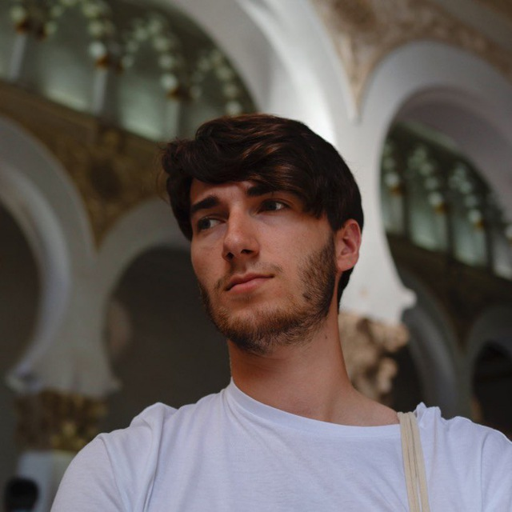

In [34]:
path = '/Users/gleb/Downloads/avataro4ka.jpg'
img = Image.open(path)
img.resize((512, 512))

In [79]:
height = 128
width = 128
angle = 0.
num_gaussians = 2
lr = 1e-2
max_steps = 4000
learning_rate_schedule = optax.constant_schedule(lr) #cosine_onecycle_schedule(max_steps, lr)

target_image = jnp.array(img.resize((height, width)), dtype=jnp.float32)[:, :, :3] / 255
background_color = target_image.mean(0).mean(0)[None, None, :]
means = jax.random.uniform(key, (num_gaussians, 2), minval=0, maxval=height, dtype=jnp.float32)
sigmas = jax.random.uniform(key, (num_gaussians, 2), minval=5, maxval=20, dtype=jnp.float32)
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in sigmas])
L = jax.lax.linalg.cholesky(covariances)
colors = jax.random.uniform(key, (num_gaussians, 4), jnp.float32, 0, 1)
colors = colors.at[:, 3].set(colors[:, 3] / colors[:, 3].sum())
r = R.from_euler('x', [angle,])
rotmats = jnp.repeat(r.as_matrix()[1:, 1:][None], num_gaussians, axis=0)

optimize_means = optax.adam(learning_rate_schedule)
optimize_cov = optax.adam(learning_rate_schedule)
optimize_colors = optax.adam(learning_rate_schedule)
optimize_rotmats = optax.adam(learning_rate_schedule)
optimize_background = optax.adam(learning_rate_schedule)

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(L)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)
opt_state_background = optimize_background.init(background_color)

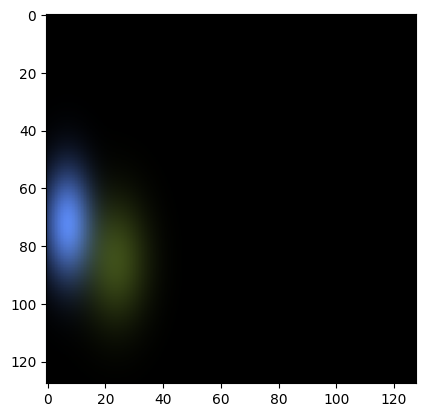

In [80]:
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity, partitioning = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

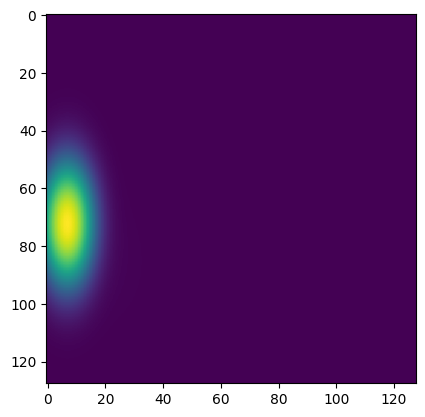

In [81]:
plt.imshow(opacity)

In [93]:
prev_stats = []
for step in range(max_steps):
    loss, gradients = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2, 3])(means, L, colors, rotmats, background_color, target_image)
    
    updates_means, opt_state_means = optimize_means.update(gradients[0], opt_state_means)
    means = optax.apply_updates(means, updates_means)

    updates_cov, opt_state_cov = optimize_cov.update(gradients[1], opt_state_cov)
    L = optax.apply_updates(L, updates_cov)

    updates_colors, opt_state_colors = optimize_colors.update(gradients[2], opt_state_colors)
    colors = optax.apply_updates(colors, updates_colors)

    updates_rotmats, opt_state_rotmats = optimize_rotmats.update(gradients[3], opt_state_rotmats)
    rotmats = optax.apply_updates(rotmats, updates_rotmats)

    # updates_background, opt_state_background = optimize_background.update(gradients[4], opt_state_background)
    # background_color = optax.apply_updates(background_color, updates_background)

    if jnp.isnan(loss):
        print(prev_stats)
        print(loss, [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients])
        break
    if step % 50 == 0:
        print(loss, step)
    prev_stats = [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients]

0.13436976 0
0.041914668 50
0.028885072 100
0.024176031 150
0.02206651 200
0.020902414 250
0.02016677 300
0.019660968 350
0.019291162 400
0.019007359 450
0.018781034 500
0.0185951 550
0.01843871 600
0.018304784 650
0.018188378 700
0.018085854 750
0.01799451 800
0.017912325 850
0.017837916 900
0.017770594 950
0.017710077 1000
0.017656207 1050
0.017608693 1100
0.017566793 1150
0.017529655 1200
0.017496422 1250
0.017466448 1300
0.017439328 1350
0.017414749 1400
0.01739245 1450
0.017372105 1500
0.017353427 1550
0.01733605 1600
0.017319728 1650
0.017304143 1700
0.01728907 1750
0.017274275 1800
0.017259596 1850
0.017244864 1900
0.017229972 1950
0.017214827 2000
0.017199356 2050
0.017183512 2100
0.017167214 2150
0.017150413 2200
0.017133005 2250
0.017114898 2300
0.017095966 2350
0.017076131 2400
0.017055342 2450
0.01703351 2500
0.017010711 2550
0.016986992 2600
0.016962454 2650
0.016937265 2700
0.016911574 2750
0.016885549 2800
0.01685924 2850
0.016832672 2900
0.016805869 2950
0.016779259 300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


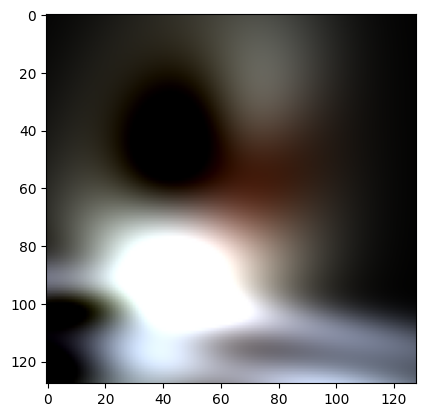

In [92]:
covariances = L@jnp.transpose(L, axes=[0, 2, 1])
background = jnp.repeat(jnp.repeat(background_color, height, axis=0), width, axis=1)
renderred_gaussians, opacity, occupancy = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

In [85]:
means.shape

(4, 2)

In [91]:
smeans = []
scovs = []
scolors = []
srotmats = []
for mean, cov, color, rotmat in zip(means, covariances, colors, rotmats):
    mean, cov, color, rotmat = split_gaussian(mean, cov, color, rotmat)
    smeans.append(mean.reshape(2, -1))
    scovs.append(cov.reshape(2, 2, 2))
    scolors.append(color.reshape(2, -1))
    srotmats.append(rotmat.reshape(2, 2, 2))

means, covariances, colors, rotmats = jnp.concatenate(smeans), jnp.concatenate(scovs), jnp.concatenate(scolors), jnp.concatenate(srotmats)
sigmas = jnp.sqrt(jnp.stack([covariances[:, 0, 0], covariances[:, 1, 1]], axis=1))

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(sigmas)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)
opt_state_background = optimize_background.init(background_color)


Array([[ 8.086459, 12.419434],
       [ 8.086459, 12.419434],
       [11.054472,  9.892498],
       [11.054472,  9.892498],
       [ 7.106157, 13.657092],
       [ 7.106157, 13.657092]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


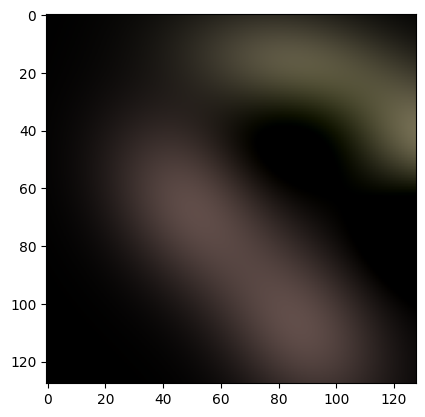

In [34]:
renderred_gaussians, opacity, occupancy = rasterize(means, covariances, colors, rotmats, background, height, width)
plt.imshow(renderred_gaussians)

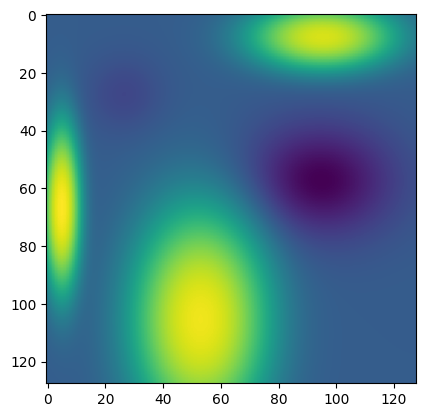

In [ ]:
plt.imshow(opacity)